In [1]:
import torch
import torch.functional as func
import torch.nn as nn

import numpy as np
import random
import tqdm
import argparse
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from models.Network import Face_Detection_Model, rgbdp_v1_twostep_model, rgbdp_v2_twostep_model, rgbdp_v3_twostep_model

import os
import os.path as osp
from re import S

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T 
import matplotlib.pyplot as plt
# from dataloader.dataloader import load_dataset, load_test_dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rgb_model = Face_Detection_Model(3).to(device)
basic_model = rgbdp_v3_twostep_model(device=device)
cloudnet = rgbdp_v1_twostep_model(device=device)
cloudnet_v2 = rgbdp_v2_twostep_model(device=device)

rgb = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0825_total_rgb/epoch_527_model.pth")
basic = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v3/epoch_660_model.pth")
cloud = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v1/epoch_165_model.pth")
cloud_v2 = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v2/epoch_967_model.pth")

rgb_model.load_state_dict(rgb['model_state_dict'])
basic_model.load_state_dict(basic['model_state_dict'])
cloudnet.load_state_dict(cloud['model_state_dict'])
cloudnet_v2.load_state_dict(cloud_v2['model_state_dict'])

sigmoid = nn.Sigmoid()
loss_fn = nn.BCEWithLogitsLoss()

g = torch.Generator()
g.manual_seed(1)

def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)        

In [3]:
class Face_Data(Dataset):

    def __init__(self, data_paths, crop=False):
        self.data_paths = data_paths
        self.crop = crop
        
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        self.transforms = T.Compose([
            T.ToTensor(),
            normalize
        ])   
        self.transforms2 = T.Compose([
            T.ToTensor()
        ])               
    
    def __getitem__(self, index):
        rgb_path = self.data_paths[index][0]
        cloud_path = self.data_paths[index][1]
        depth_path = self.data_paths[index][2]   
             
        # crop setting
        crop_width = 90
        crop_height = 150
        mid_x, mid_y = 90, 90
        offset_x, offset_y = crop_width//2, crop_height//2
        
        # RGB open and crop 
        rgb_data = cv2.imread(rgb_path)
        rgb_data = cv2.cvtColor(rgb_data, cv2.COLOR_BGR2RGB)
        rgb_data = cv2.resize(rgb_data, (180,180), interpolation=cv2.INTER_CUBIC)
        if self.crop == True:
            rgb_data = rgb_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]     
        if self.transforms is not None :
            rgb_data = self.transforms(rgb_data)
            
        # Depth open 
        depth_data = cv2.imread(depth_path)
        depth_data = cv2.cvtColor(depth_data, cv2.COLOR_BGR2GRAY)
        depth_data = cv2.resize(depth_data, (180,180), interpolation=cv2.INTER_CUBIC)        
        if self.transforms2 is not None :
            depth_data = self.transforms2(depth_data)            
            
        # Point Cloud(192, 256, 3) open and crop 
        cloud_data = np.load(cloud_path)
        cloud_data = cv2.resize(cloud_data, (180,180), interpolation=cv2.INTER_CUBIC)
        cloud_data += 5
        if self.crop == True:
            cloud_data = cloud_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]
        
        # Point Cloud and Depth Scaling
        shift_value = 0
        xcoor = np.array(cloud_data[:, :, 0] + shift_value)
        ycoor = np.array(cloud_data[:, :, 1] + shift_value)
        zcoor = np.array(cloud_data[:, :, 2] + shift_value)
        # depth = np.array(cloud_data[:, :, 3] + shift_value)

        # Stadardivation
        # xcoor = (xcoor-xcoor.mean())/xcoor.std()
        # ycoor = (ycoor-ycoor.mean())/ycoor.std()
        # zcoor = (zcoor-zcoor.mean())/zcoor.std()
        # depth = (depth-depth.mean())/depth.std()    
        
        # Min Max         
        xcoor = (xcoor-xcoor.min())/(xcoor.max()-xcoor.min())
        ycoor = (ycoor-ycoor.min())/(ycoor.max()-ycoor.min())
        zcoor = (zcoor-zcoor.min())/(zcoor.max()-zcoor.min())
        # depth = (depth-depth.min())/(depth.max()-depth.min())  
        
        scaled_cloud_data = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:]]) 
        # scaled_depth_data = depth[np.newaxis,:]
        
        # label - { 0 : real , 1 : mask }
        if 'bonafide' in rgb_path :
            label = 0
        elif 'attack_mask' in rgb_path :
            label = 1
        elif 'attack_replay' in rgb_path :
            label = 1
        elif 'attack_paper' in rgb_path :
            label = 1
        # return rgb_data, scaled_cloud_data, scaled_depth_data, label
        return rgb_data, scaled_cloud_data, depth_data, label
    def __len__(self):
        return len(self.data_paths)
    
    
def load_dataset(args): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    data_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/1. Indoor'
    npy_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/NPY_Files/1. Indoor'

    traindata_count = [i for i in range(1,10)] # 1~9
    testdata_count = [i for i in range(10,13)]  # 10~12    
 
    train_img_paths = []
    for i in traindata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB 
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]       
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        train_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            train_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            train_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            train_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
 
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
        
    random.shuffle(train_img_paths)
    random.shuffle(test_img_paths)

    print(len(train_img_paths))
    print(len(test_img_paths))
    
#     train_dataset=Face_Data(train_img_paths, False)
#     test_dataset=Face_Data(test_img_paths, False) 

    return train_img_paths, test_img_paths


def load_test_dataset(args, dir_name): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    LDFAS_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/'
    data_path = osp.join(LDFAS_path, dir_name)
    npy_path = osp.join(LDFAS_path, "NPY_Files", dir_name)
         
    testdata_count = [i for i in range(1,13)]  # 1~12    
#     testdata_count = [i for i in range(7,13)]  # 1~12    
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
               
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
     
    random.shuffle(test_img_paths)
    print(len(test_img_paths))
    
#     test_dataset=Face_Data(test_img_paths, False) 

    return test_img_paths


In [4]:
args = "rpm"

_, indoor_test_paths = load_dataset(args)
outdoor_test_paths = load_test_dataset(args, "2. Outdoor")
darkdoor_test_pathst = load_test_dataset(args, "3. Indoor_dark")

indoor_testset=Face_Data(indoor_test_paths, False)
outdoor_testset=Face_Data(outdoor_test_paths, False)
darkdoor_testset=Face_Data(darkdoor_test_pathst, False)

indoor_dataloader= DataLoader(indoor_testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
outdoor_dataloader = DataLoader(outdoor_testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
darkdoor_dataloader = DataLoader(darkdoor_testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)    

720
240
960
960


In [5]:
rgb_model.eval()
basic_model.eval()
cloudnet.eval()
cloudnet_v2.eval()

perform_rgb = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}
perform_basic = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}
perform_cloud = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}
perform_cloud_v2 = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}


for data in indoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud = cloudnet(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)
    
    logits_rgb = logits_rgb[:,0]  # logtit (4.2) 텐서이던데 첫째는 batch 이겠고. 근데 왜 0번째 값만 쓸까?
    logits_basic = logits_basic[:,0]
    logits_cloud = logits_cloud[:,0]
    logits_cloud_v2 = logits_cloud_v2[:,0]
    
    probs_rgb = sigmoid(logits_rgb)
    probs_basic = sigmoid(logits_basic)
    probs_cloud = sigmoid(logits_cloud)
    probs_cloud_v2 = sigmoid(logits_cloud_v2)
    
    perform_rgb["indoor_prob"] += probs_rgb.cpu().detach().tolist()
    perform_basic["indoor_prob"] += probs_basic.cpu().detach().tolist()
    perform_cloud["indoor_prob"] += probs_cloud.cpu().detach().tolist()
    perform_cloud_v2["indoor_prob"] += probs_cloud_v2.cpu().detach().tolist()
        
    perform_rgb["indoor_true"] += label.cpu().detach().tolist() 
    perform_basic["indoor_true"] += label.cpu().detach().tolist() 
    perform_cloud["indoor_true"] += label.cpu().detach().tolist()
    perform_cloud_v2["indoor_true"] += label.cpu().detach().tolist()
    
print(len(perform_rgb["indoor_prob"]))
print(len(perform_basic["indoor_prob"]))
print(len(perform_cloud["indoor_prob"]))
print(len(perform_cloud_v2["indoor_prob"]))
print(len(perform_rgb["indoor_true"]))
print(len(perform_basic["indoor_true"]))
print(len(perform_cloud["indoor_true"]))
print(len(perform_cloud_v2["indoor_true"]))

240
240
240
240
240
240
240
240


In [6]:
for data in outdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud = cloudnet(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)
    
    logits_rgb = logits_rgb[:,0]  # logtit (4.2) 텐서이던데 첫째는 batch 이겠고. 근데 왜 0번째 값만 쓸까?
    logits_basic = logits_basic[:,0]
    logits_cloud = logits_cloud[:,0]
    logits_cloud_v2 = logits_cloud_v2[:,0]
    
    probs_rgb = sigmoid(logits_rgb)
    probs_basic = sigmoid(logits_basic)
    probs_cloud = sigmoid(logits_cloud)
    probs_cloud_v2 = sigmoid(logits_cloud_v2)
    
    perform_rgb["outdoor_prob"] += probs_rgb.cpu().detach().tolist()
    perform_basic["outdoor_prob"] += probs_basic.cpu().detach().tolist()
    perform_cloud["outdoor_prob"] += probs_cloud.cpu().detach().tolist()
    perform_cloud_v2["outdoor_prob"] += probs_cloud_v2.cpu().detach().tolist()
    
    perform_rgb["outdoor_true"] += label.cpu().detach().tolist() 
    perform_basic["outdoor_true"] += label.cpu().detach().tolist() 
    perform_cloud["outdoor_true"] += label.cpu().detach().tolist()
    perform_cloud_v2["outdoor_true"] += label.cpu().detach().tolist()
    
print(len(perform_rgb["outdoor_prob"]))
print(len(perform_basic["outdoor_prob"]))
print(len(perform_cloud["outdoor_prob"]))
print(len(perform_cloud_v2["outdoor_prob"]))
print(len(perform_rgb["outdoor_true"]))
print(len(perform_basic["outdoor_true"]))
print(len(perform_cloud["outdoor_true"]))
print(len(perform_cloud_v2["outdoor_true"]))

for data in darkdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud = cloudnet(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)
    
    logits_rgb = logits_rgb[:,0]  # logtit (4.2) 텐서이던데 첫째는 batch 이겠고. 근데 왜 0번째 값만 쓸까?
    logits_basic = logits_basic[:,0]
    logits_cloud = logits_cloud[:,0]
    logits_cloud_v2 = logits_cloud_v2[:,0]
    
    probs_rgb = sigmoid(logits_rgb)
    probs_basic = sigmoid(logits_basic)
    probs_cloud = sigmoid(logits_cloud)
    probs_cloud_v2 = sigmoid(logits_cloud_v2)
    
    perform_rgb["darkdoor_prob"] += probs_rgb.cpu().detach().tolist()
    perform_basic["darkdoor_prob"] += probs_basic.cpu().detach().tolist()
    perform_cloud["darkdoor_prob"] += probs_cloud.cpu().detach().tolist()
    perform_cloud_v2["darkdoor_prob"] += probs_cloud_v2.cpu().detach().tolist()
    
    perform_rgb["darkdoor_true"] += label.cpu().detach().tolist() 
    perform_basic["darkdoor_true"] += label.cpu().detach().tolist() 
    perform_cloud["darkdoor_true"] += label.cpu().detach().tolist()
    perform_cloud_v2["darkdoor_true"] += label.cpu().detach().tolist()
    
print(len(perform_rgb["darkdoor_prob"]))
print(len(perform_basic["darkdoor_prob"]))
print(len(perform_cloud["darkdoor_prob"]))
print(len(perform_cloud_v2["darkdoor_prob"]))
print(len(perform_rgb["darkdoor_true"]))
print(len(perform_basic["darkdoor_true"]))
print(len(perform_cloud["darkdoor_true"]))
print(len(perform_cloud_v2["darkdoor_true"]))
    

960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960


In [7]:
# Indoor 

tn, fp, fn, tp = confusion_matrix(np.array(perform_rgb["indoor_true"]), np.round(perform_rgb["indoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_rgb["indoor_true"], perform_rgb["indoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_rgb["indoor_true"], perform_rgb["indoor_prob"])

print("Indoor (RGB)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")


tn, fp, fn, tp = confusion_matrix(np.array(perform_basic["indoor_true"]), np.round(perform_basic["indoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_basic["indoor_true"], perform_basic["indoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_basic["indoor_true"], perform_basic["indoor_prob"])
                        
print("Indoor (Resnet34)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud["indoor_true"]), np.round(perform_cloud["indoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud["indoor_true"], perform_cloud["indoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud["indoor_true"], perform_cloud["indoor_prob"])

print("Indoor (CloudNet)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud_v2["indoor_true"]), np.round(perform_cloud_v2["indoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud_v2["indoor_true"], perform_cloud_v2["indoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud_v2["indoor_true"], perform_cloud_v2["indoor_prob"])

print("Indoor (CloudNet_v2)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



# Outdoor

tn, fp, fn, tp = confusion_matrix(np.array(perform_rgb["outdoor_true"]), np.round(perform_rgb["outdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_rgb["outdoor_true"], perform_rgb["outdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_rgb["outdoor_true"], perform_rgb["outdoor_prob"])

print("Outdoor (RGB)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_basic["outdoor_true"]), np.round(perform_basic["outdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_basic["outdoor_true"], perform_basic["outdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_basic["outdoor_true"], perform_basic["outdoor_prob"])

print("Outdoor (Resnet34)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")


tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud["outdoor_true"]), np.round(perform_cloud["outdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud["outdoor_true"], perform_cloud["outdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud["outdoor_true"], perform_cloud["outdoor_prob"])

print("Outdoor (CloudNet)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud_v2["outdoor_true"]), np.round(perform_cloud_v2["outdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud_v2["outdoor_true"], perform_cloud_v2["outdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud_v2["outdoor_true"], perform_cloud_v2["outdoor_prob"])

print("Outdoor (CloudNet_v2)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



# Dark door

tn, fp, fn, tp = confusion_matrix(np.array(perform_rgb["darkdoor_true"]), np.round(perform_rgb["darkdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_rgb["darkdoor_true"], perform_rgb["darkdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_rgb["darkdoor_true"], perform_rgb["darkdoor_prob"])

print("Dark (RGB)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_basic["darkdoor_true"]), np.round(perform_basic["darkdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_basic["darkdoor_true"], perform_basic["darkdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_basic["darkdoor_true"], perform_basic["darkdoor_prob"])

print("Dark (Resnet34)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud["darkdoor_true"]), np.round(perform_cloud["darkdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud["darkdoor_true"], perform_cloud["darkdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud["darkdoor_true"], perform_cloud["darkdoor_prob"])

print("Dark (CloudNet)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2=  fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud_v2["darkdoor_true"]), np.round(perform_cloud_v2["darkdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud_v2["darkdoor_true"], perform_cloud_v2["darkdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud_v2["darkdoor_true"], perform_cloud_v2["darkdoor_prob"])

print("Darkdoor (CloudNet_v2)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

eer1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer2= fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"far: {far:.4f} frr: {frr:.4f} eer1: {eer1:.4f} eer2: {eer2:.4f}")



Indoor (RGB)
BPCER: 0.1222
APCER: 0.0000
ACER: 0.0611
AUC Value: 0.9958, 0.9958

far: 0.0000 frr: 0.1222 eer1: 0.0500 eer2: 0.0389
Indoor (Resnet34)
BPCER: 0.0556
APCER: 0.0000
ACER: 0.0278
AUC Value: 0.9922, 0.9922

far: 0.0000 frr: 0.0556 eer1: 0.0167 eer2: 0.0389
Indoor (CloudNet)
BPCER: 0.0000
APCER: 0.0000
ACER: 0.0000
AUC Value: 1.0000, 1.0000

far: 0.0000 frr: 0.0000 eer1: 0.0000 eer2: 0.0000
Indoor (CloudNet_v2)
BPCER: 0.0000
APCER: 0.0000
ACER: 0.0000
AUC Value: 1.0000, 1.0000

far: 0.0000 frr: 0.0000 eer1: 0.0000 eer2: 0.0000
Outdoor (RGB)
BPCER: 0.3264
APCER: 0.6667
ACER: 0.4965
AUC Value: 0.5125, 0.5125

far: 0.6667 frr: 0.3264 eer1: 0.5292 eer2: 0.4375
Outdoor (Resnet34)
BPCER: 0.3944
APCER: 0.0042
ACER: 0.1993
AUC Value: 0.9262, 0.9262

far: 0.0042 frr: 0.3944 eer1: 0.1375 eer2: 0.1403
Outdoor (CloudNet)
BPCER: 0.1583
APCER: 0.1750
ACER: 0.1667
AUC Value: 0.9022, 0.9022

far: 0.1750 frr: 0.1583 eer1: 0.1708 eer2: 0.1667
Outdoor (CloudNet_v2)
BPCER: 0.3028
APCER: 0.0125
AC

In [8]:
tn, fp, fn, tp = confusion_matrix(np.array(perform_cloud["darkdoor_true"]), np.round(perform_cloud["darkdoor_prob"])).ravel()
apcer = fp / (fp + tn)
bpcer = fn / (fn + tp)
acer = (apcer + bpcer) / 2
fpr, tpr, thresholds = roc_curve(perform_cloud["darkdoor_true"], perform_cloud["darkdoor_prob"], pos_label=1)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(perform_cloud["darkdoor_true"], perform_cloud["darkdoor_prob"])

print("Dark (CloudNet)")
print(f"BPCER: {bpcer:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"ACER: {acer:.4f}")
print(f"AUC Value: {auc_value:.4f}, {roc_auc:.4f}")
print("")

far = fp / (fp + tn)
frr = fn / (fn + tp)
fnr = 1 - tpr

Dark (CloudNet)
BPCER: 0.3139
APCER: 0.0042
ACER: 0.1590
AUC Value: 0.8357, 0.8357



In [9]:
far,fpr

(0.004166666666666667,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00416667, 0.00416667, 0.00833333, 0.00833333, 0.0125    ,
        0.0125    , 0.04166667, 0.04166667, 0.05      , 0.05      ,
        0.05833333, 0.05833333, 0.06666667, 0.06666667, 0.07083333,
        0.07083333, 0.075     , 0.075     , 0.07916667, 0.07916667,
        0.0875    , 0.0875    , 0.09166667, 0.09166667, 0.09583333,
        0.09583333, 0.10833333, 0.10833333, 0.1125    , 0.1125    ,
        0.12083333, 0.12083333, 0.125     , 0.125     , 0.1625    ,
        0.1625    , 0.16666667, 0.16666667, 0.17083333, 0.17083333,
        0.17916667, 0.17916667, 0.19583333, 0.19583333, 0.2375    ,
        0.2375    , 0.25416667, 0.25416667, 0.25833333, 0.25833333,
        0.2625    , 0.2625    , 0.26666667, 0.26666667, 0.28333333,
        0.28333333, 0.2875    , 0.2875    , 0.30833333, 0.30833333,
        0.32083333, 0.32083333, 0.325     , 0.325     , 0.33333333,
        0.33333333, 0.337

Indoor AUC (rgb): 0.9958
Indoor AUC (resnet34): 0.9922
Indoor AUC (cloudnet): 1.0000
Indoor AUC (cloudnet_v2): 1.0000
RGB 	err avg: 0.0444 	err1: 0.0500 	err2: 0.0389
Basic 	err avg: 0.0278 	err1: 0.0167 	err2: 0.0389
Cloud 	err avg: 0.0000 	err1: 0.0000 	err2: 0.0000
Cloud2 	err avg: 0.0000 	err1: 0.0000 	err2: 0.0000


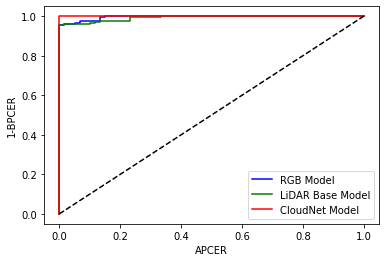

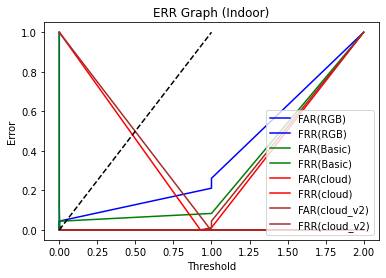

In [16]:
fpr_rgb, tpr_rgb, thresholds_rgb = roc_curve(perform_rgb["indoor_true"], perform_rgb["indoor_prob"], pos_label=1)
fpr_basic, tpr_basic, thresholds_basic = roc_curve(perform_basic["indoor_true"], perform_basic["indoor_prob"], pos_label=1)
fpr_cloud, tpr_cloud, thresholds_cloud = roc_curve(perform_cloud["indoor_true"], perform_cloud["indoor_prob"], pos_label=1)
fpr_cloud_v2, tpr_cloud_v2, thresholds_cloud_v2 = roc_curve(perform_cloud_v2["indoor_true"], perform_cloud_v2["indoor_prob"], pos_label=1)

fig = plt.figure()
# plt.title("ROC Curve (Indoor)")
plt.xlabel("APCER")
plt.ylabel("1-BPCER")    
plt.plot(fpr_rgb, tpr_rgb, color='blue', label="RGB Model")
plt.plot(fpr_basic, tpr_basic, color='green', label="LiDAR Base Model")
# plt.plot(fpr_cloud, tpr_cloud, color='red', label="CloudNet")
plt.plot(fpr_cloud_v2, tpr_cloud_v2, color='red', label="CloudNet Model")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')
# plt.text(0.55, 0.4, f"Best threshold:{optimal_threshold:4f}")
# plt.text(0.55, 0.3, f"Best 1-BPCER:{tpr[optimal_idx]:4f}")
# plt.text(0.55, 0.2, f"Best APCER:{fpr[optimal_idx]:4f}")
# plt.text(0.55, 0.1, f"Area Under the Curve:{auc_value:4f}")
# plt.savefig(path+f'/{title_info}_roc_curve.png')
# plt.close(fig)

auc_rgb = auc(fpr_rgb, tpr_rgb)
auc_basic = auc(fpr_basic, tpr_basic)
auc_cloud = auc(fpr_cloud, tpr_cloud)
auc_cloud_v2 = auc(fpr_cloud_v2, tpr_cloud_v2)
print(f"Indoor AUC (rgb): {auc_rgb:.4f}")
print(f"Indoor AUC (resnet34): {auc_basic:.4f}")
print(f"Indoor AUC (cloudnet): {auc_cloud:.4f}")
print(f"Indoor AUC (cloudnet_v2): {auc_cloud_v2:.4f}")


fnr_rgb = 1 - tpr_rgb
fnr_basic = 1 - tpr_basic
fnr_cloud = 1 - tpr_cloud
fnr_cloud_v2 = 1 - tpr_cloud_v2

eer_threshold_rgb = thresholds_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer1_rgb = fpr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer2_rgb = fnr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer_rgb = (eer1_rgb + eer2_rgb) / 2

eer_threshold_basic = thresholds_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer1_basic = fpr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer2_basic = fnr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer_basic = (eer1_basic + eer2_basic) / 2

eer_threshold_cloud = thresholds_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer1_cloud = fpr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer2_cloud = fnr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer_cloud = (eer1_cloud + eer2_cloud) / 2

eer_threshold_cloud_v2 = thresholds_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer1_cloud_v2 = fpr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer2_cloud_v2 = fnr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer_cloud_v2 = (eer1_cloud_v2 + eer2_cloud_v2) / 2

print(f"RGB \terr avg: {eer_rgb:.4f} \terr1: {eer1_rgb:.4f} \terr2: {eer2_rgb:.4f}")
print(f"Basic \terr avg: {eer_basic:.4f} \terr1: {eer1_basic:.4f} \terr2: {eer2_basic:.4f}")
print(f"Cloud \terr avg: {eer_cloud:.4f} \terr1: {eer1_cloud:.4f} \terr2: {eer2_cloud:.4f}")
print(f"Cloud2 \terr avg: {eer_cloud_v2:.4f} \terr1: {eer1_cloud_v2:.4f} \terr2: {eer2_cloud_v2:.4f}")

frr_rgb = 1 - tpr_rgb
far_rgb = fpr_rgb
frr_basic = 1 - tpr_basic
far_basic = fpr_basic
frr_cloud = 1 - tpr_cloud
far_cloud = fpr_cloud
frr_cloud_v2 = 1 - tpr_cloud_v2
far_cloud_v2 = fpr_cloud_v2

fig = plt.figure()
plt.title("ERR Graph (Indoor)")
plt.xlabel("Threshold")
plt.ylabel("Error")    
plt.plot(thresholds_rgb, far_rgb, color='blue', label="FAR(RGB)")
plt.plot(thresholds_rgb, frr_rgb, color='blue', label="FRR(RGB)")
plt.plot(thresholds_basic, far_basic, color='Green', label="FAR(Basic)")
plt.plot(thresholds_basic, frr_basic, color='Green', label="FRR(Basic)")
plt.plot(thresholds_cloud, far_cloud, color='red', label="FAR(cloud)")
plt.plot(thresholds_cloud, frr_cloud, color='red', label="FRR(cloud)")
plt.plot(thresholds_cloud_v2, far_cloud_v2, color='brown', label="FAR(cloud_v2)")
plt.plot(thresholds_cloud_v2, frr_cloud_v2, color='brown', label="FRR(cloud_v2)")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')



Outdoor AUC (rgb): 0.5125
Outdoor AUC (resnet34): 0.9262
Outdoor AUC (cloudnet): 0.9022
Outdoor AUC (cloudnet_v2): 0.9503
RGB 	err avg: 0.4833 	err1: 0.5292 	err2: 0.4375
Basic 	err avg: 0.1389 	err1: 0.1375 	err2: 0.1403
Cloud 	err avg: 0.1687 	err1: 0.1708 	err2: 0.1667
Cloud2 	err avg: 0.1722 	err1: 0.1708 	err2: 0.1736


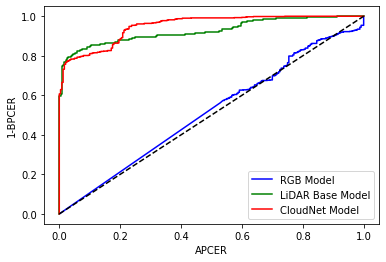

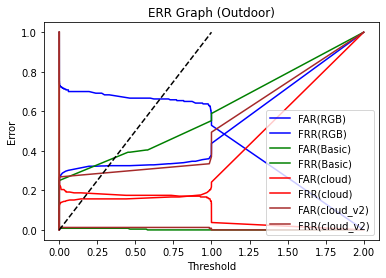

In [17]:
fpr_rgb, tpr_rgb, thresholds_rgb = roc_curve(perform_rgb["outdoor_true"], perform_rgb["outdoor_prob"], pos_label=1)
fpr_basic, tpr_basic, thresholds_basic = roc_curve(perform_basic["outdoor_true"], perform_basic["outdoor_prob"], pos_label=1)
fpr_cloud, tpr_cloud, thresholds_cloud = roc_curve(perform_cloud["outdoor_true"], perform_cloud["outdoor_prob"], pos_label=1)
fpr_cloud_v2, tpr_cloud_v2, thresholds_cloud_v2 = roc_curve(perform_cloud_v2["outdoor_true"], perform_cloud_v2["outdoor_prob"], pos_label=1)


fig = plt.figure()
# plt.title("ROC Curve (Outdoor)")
plt.xlabel("APCER")
plt.ylabel("1-BPCER")    
plt.plot(fpr_rgb, tpr_rgb, color='blue', label="RGB Model")
plt.plot(fpr_basic, tpr_basic, color='green', label="LiDAR Base Model")
# plt.plot(fpr_cloud, tpr_cloud, color='red', label="CloudNet")
plt.plot(fpr_cloud_v2, tpr_cloud_v2, color='red', label="CloudNet Model")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')
# plt.text(0.55, 0.4, f"Best threshold:{optimal_threshold:4f}")
# plt.text(0.55, 0.3, f"Best 1-BPCER:{tpr[optimal_idx]:4f}")
# plt.text(0.55, 0.2, f"Best APCER:{fpr[optimal_idx]:4f}")
# plt.text(0.55, 0.1, f"Area Under the Curve:{auc_value:4f}")
# plt.savefig(path+f'/{title_info}_roc_curve.png')
# plt.close(fig)

auc_rgb = auc(fpr_rgb, tpr_rgb)
auc_basic = auc(fpr_basic, tpr_basic)
auc_cloud = auc(fpr_cloud, tpr_cloud)
auc_cloud_v2 = auc(fpr_cloud_v2, tpr_cloud_v2)
print(f"Outdoor AUC (rgb): {auc_rgb:.4f}")
print(f"Outdoor AUC (resnet34): {auc_basic:.4f}")
print(f"Outdoor AUC (cloudnet): {auc_cloud:.4f}")
print(f"Outdoor AUC (cloudnet_v2): {auc_cloud_v2:.4f}")


fnr_rgb = 1 - tpr_rgb
fnr_basic = 1 - tpr_basic
fnr_cloud = 1 - tpr_cloud
fnr_cloud_v2 = 1 - tpr_cloud_v2

eer_threshold_rgb = thresholds_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer1_rgb = fpr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer2_rgb = fnr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer_rgb = (eer1_rgb + eer2_rgb) / 2

eer_threshold_basic = thresholds_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer1_basic = fpr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer2_basic = fnr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer_basic = (eer1_basic + eer2_basic) / 2

eer_threshold_cloud = thresholds_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer1_cloud = fpr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer2_cloud = fnr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer_cloud = (eer1_cloud + eer2_cloud) / 2

eer_threshold_cloud_v2 = thresholds_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer1_cloud_v2 = fpr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer2_cloud_v2 = fnr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer_cloud_v2 = (eer1_cloud_v2 + eer2_cloud_v2) / 2

print(f"RGB \terr avg: {eer_rgb:.4f} \terr1: {eer1_rgb:.4f} \terr2: {eer2_rgb:.4f}")
print(f"Basic \terr avg: {eer_basic:.4f} \terr1: {eer1_basic:.4f} \terr2: {eer2_basic:.4f}")
print(f"Cloud \terr avg: {eer_cloud:.4f} \terr1: {eer1_cloud:.4f} \terr2: {eer2_cloud:.4f}")
print(f"Cloud2 \terr avg: {eer_cloud_v2:.4f} \terr1: {eer1_cloud_v2:.4f} \terr2: {eer2_cloud_v2:.4f}")



frr_rgb = 1 - tpr_rgb
far_rgb = fpr_rgb
frr_basic = 1 - tpr_basic
far_basic = fpr_basic
frr_cloud = 1 - tpr_cloud
far_cloud = fpr_cloud
frr_cloud_v2 = 1 - tpr_cloud_v2
far_cloud_v2 = fpr_cloud_v2

fig = plt.figure()
plt.title("ERR Graph (Outdoor)")
plt.xlabel("Threshold")
plt.ylabel("Error")    
plt.plot(thresholds_rgb, far_rgb, color='blue', label="FAR(RGB)")
plt.plot(thresholds_rgb, frr_rgb, color='blue', label="FRR(RGB)")
plt.plot(thresholds_basic, far_basic, color='Green', label="FAR(Basic)")
plt.plot(thresholds_basic, frr_basic, color='Green', label="FRR(Basic)")
plt.plot(thresholds_cloud, far_cloud, color='red', label="FAR(cloud)")
plt.plot(thresholds_cloud, frr_cloud, color='red', label="FRR(cloud)")
plt.plot(thresholds_cloud_v2, far_cloud_v2, color='brown', label="FAR(cloud_v2)")
plt.plot(thresholds_cloud_v2, frr_cloud_v2, color='brown', label="FRR(cloud_v2)")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')

Darkdoor AUC (rgb): 0.6211
Darkdoor AUC (resnet34): 0.8423
Darkdoor AUC (cloudnet): 0.8357
Darkdoor AUC (cloudnet_v2): 0.8330
RGB 	err avg: 0.3792 	err1: 0.3792 	err2: 0.3792
Basic 	err avg: 0.2785 	err1: 0.2792 	err2: 0.2778
Cloud 	err avg: 0.2375 	err1: 0.2375 	err2: 0.2375
Cloud2 	err avg: 0.2708 	err1: 0.2750 	err2: 0.2667


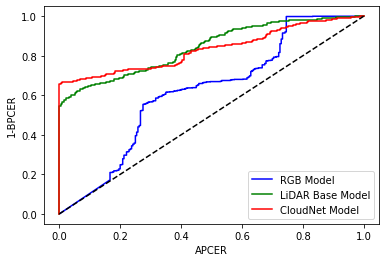

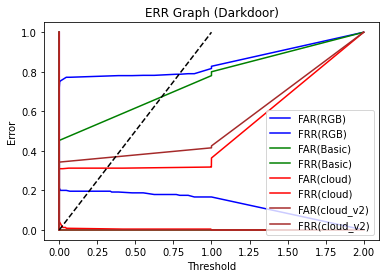

In [18]:
fpr_rgb, tpr_rgb, thresholds_rgb = roc_curve(perform_rgb["darkdoor_true"], perform_rgb["darkdoor_prob"], pos_label=1)
fpr_basic, tpr_basic, thresholds_basic = roc_curve(perform_basic["darkdoor_true"], perform_basic["darkdoor_prob"], pos_label=1)
fpr_cloud, tpr_cloud, thresholds_cloud = roc_curve(perform_cloud["darkdoor_true"], perform_cloud["darkdoor_prob"], pos_label=1)
fpr_cloud_v2, tpr_cloud_v2, thresholds_cloud_v2 = roc_curve(perform_cloud_v2["darkdoor_true"], perform_cloud_v2["darkdoor_prob"], pos_label=1)

fig = plt.figure()

# plt.title("ROC Curve (Indoor-dark)")
plt.xlabel("APCER")
plt.ylabel("1-BPCER")    
plt.plot(fpr_rgb, tpr_rgb, color='blue', label="RGB Model")
plt.plot(fpr_basic, tpr_basic, color='green', label="LiDAR Base Model")
# plt.plot(fpr_cloud, tpr_cloud, color='red', label="CloudNet")
plt.plot(fpr_cloud_v2, tpr_cloud_v2, color='red', label="CloudNet Model")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')
# plt.text(0.55, 0.4, f"Best threshold:{optimal_threshold:4f}")
# plt.text(0.55, 0.3, f"Best 1-BPCER:{tpr[optimal_idx]:4f}")
# plt.text(0.55, 0.2, f"Best APCER:{fpr[optimal_idx]:4f}")
# plt.text(0.55, 0.1, f"Area Under the Curve:{auc_value:4f}")
# plt.savefig(path+f'/{title_info}_roc_curve.png')
# plt.close(fig)

auc_rgb = auc(fpr_rgb, tpr_rgb)
auc_basic = auc(fpr_basic, tpr_basic)
auc_cloud = auc(fpr_cloud, tpr_cloud)
auc_cloud_v2 = auc(fpr_cloud_v2, tpr_cloud_v2)
print(f"Darkdoor AUC (rgb): {auc_rgb:.4f}")
print(f"Darkdoor AUC (resnet34): {auc_basic:.4f}")
print(f"Darkdoor AUC (cloudnet): {auc_cloud:.4f}")
print(f"Darkdoor AUC (cloudnet_v2): {auc_cloud_v2:.4f}")

fnr_rgb = 1 - tpr_rgb
fnr_basic = 1 - tpr_basic
fnr_cloud = 1 - tpr_cloud
fnr_cloud_v2 = 1 - tpr_cloud_v2

eer_threshold_rgb = thresholds_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer1_rgb = fpr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer2_rgb = fnr_rgb[np.nanargmin(np.absolute((fnr_rgb - fpr_rgb)))]
eer_rgb = (eer1_rgb + eer2_rgb) / 2

eer_threshold_basic = thresholds_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer1_basic = fpr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer2_basic = fnr_basic[np.nanargmin(np.absolute((fnr_basic - fpr_basic)))]
eer_basic = (eer1_basic + eer2_basic) / 2

eer_threshold_cloud = thresholds_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer1_cloud = fpr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer2_cloud = fnr_cloud[np.nanargmin(np.absolute((fnr_cloud - fpr_cloud)))]
eer_cloud = (eer1_cloud + eer2_cloud) / 2

eer_threshold_cloud_v2 = thresholds_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer1_cloud_v2 = fpr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer2_cloud_v2 = fnr_cloud_v2[np.nanargmin(np.absolute((fnr_cloud_v2 - fpr_cloud_v2)))]
eer_cloud_v2 = (eer1_cloud_v2 + eer2_cloud_v2) / 2

print(f"RGB \terr avg: {eer_rgb:.4f} \terr1: {eer1_rgb:.4f} \terr2: {eer2_rgb:.4f}")
print(f"Basic \terr avg: {eer_basic:.4f} \terr1: {eer1_basic:.4f} \terr2: {eer2_basic:.4f}")
print(f"Cloud \terr avg: {eer_cloud:.4f} \terr1: {eer1_cloud:.4f} \terr2: {eer2_cloud:.4f}")
print(f"Cloud2 \terr avg: {eer_cloud_v2:.4f} \terr1: {eer1_cloud_v2:.4f} \terr2: {eer2_cloud_v2:.4f}")


frr_rgb = 1 - tpr_rgb
far_rgb = fpr_rgb
frr_basic = 1 - tpr_basic
far_basic = fpr_basic
frr_cloud = 1 - tpr_cloud
far_cloud = fpr_cloud
frr_cloud_v2 = 1 - tpr_cloud_v2
far_cloud_v2 = fpr_cloud_v2

fig = plt.figure()
plt.title("ERR Graph (Darkdoor)")
plt.xlabel("Threshold")
plt.ylabel("Error")    
plt.plot(thresholds_rgb, far_rgb, color='blue', label="FAR(RGB)")
plt.plot(thresholds_rgb, frr_rgb, color='blue', label="FRR(RGB)")
plt.plot(thresholds_basic, far_basic, color='Green', label="FAR(Basic)")
plt.plot(thresholds_basic, frr_basic, color='Green', label="FRR(Basic)")
plt.plot(thresholds_cloud, far_cloud, color='red', label="FAR(cloud)")
plt.plot(thresholds_cloud, frr_cloud, color='red', label="FRR(cloud)")
plt.plot(thresholds_cloud_v2, far_cloud_v2, color='brown', label="FAR(cloud_v2)")
plt.plot(thresholds_cloud_v2, frr_cloud_v2, color='brown', label="FRR(cloud_v2)")
plt.plot([0,1], [0,1], color='black', linestyle='--') 
plt.legend(loc='lower right')